<a href="https://colab.research.google.com/github/zaneprice5/SBA_PPP_loan_analysis/blob/main/SBA_loan_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploration of Small Business Administration PPP loan data

This is a dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/nflovejoy/paycheck-protection-program-loan-data). 
I will primarily conduct EDA on this dataset and potentially run some modeling.

Sources:
https://seaborn.pydata.org/tutorial/distributions.html;
https://www.kaggle.com/code/apapiu/regularized-linear-models;
https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection;
https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python



###*Once we look at how many of the categorical features are missing values, it is pretty much useless to do any actual modeling on this data. But, we'll keep the notebook for EDA purposes and there is some really useful polotting here.*

In [ ]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import mutual_info_classif 
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import LinearSVC


from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import os

from sklearn.metrics import classification_report,confusion_matrix,f1_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# read in the data and check it out
df = pd.read_csv('/content/public_150k_plus_230101.csv')


dfsmall = df[:500]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LoanNumber                   4581 non-null   int64  
 1   DateApproved                 4581 non-null   object 
 2   SBAOfficeCode                4581 non-null   int64  
 3   ProcessingMethod             4581 non-null   object 
 4   BorrowerName                 4580 non-null   object 
 5   BorrowerAddress              4573 non-null   object 
 6   BorrowerCity                 4573 non-null   object 
 7   BorrowerState                4568 non-null   object 
 8   BorrowerZip                  4573 non-null   object 
 9   LoanStatusDate               4436 non-null   object 
 10  LoanStatus                   4580 non-null   object 
 11  Term                         4580 non-null   float64
 12  SBAGuarantyPercentage        4580 non-null   float64
 13  InitialApprovalAmo

In [ ]:
#let's check for missing values and from what proportion of the samples they're missing. 

missing_values = df.isnull().sum() / len(df)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)

missing_values = missing_values.to_frame()
missing_values.columns = ['count']
missing_values.index.names = ['Name']
missing_values['Name'] = missing_values.index


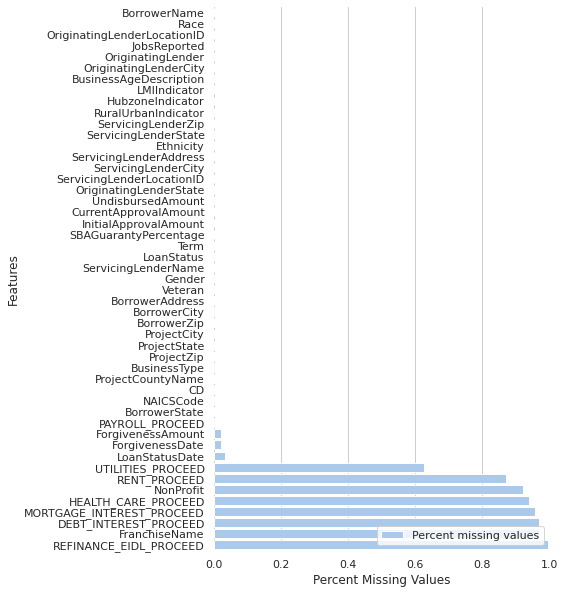

In [ ]:
#plot to check it out

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="count", y="Name", data=missing_values,
            label="Percent missing values", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,1), ylabel="Features",
       xlabel="Percent Missing Values")
sns.despine(left=True, bottom=True)

In [ ]:
#let's remove these features from the dataframe that have more than 60% of their values missing. 

df2 = missing_values.loc[missing_values['count'] > .6]

miss_features = [i for i in df2['Name']]
# miss_features
df.drop(miss_features, axis = 1, inplace = True
        )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LoanNumber                   4581 non-null   int64  
 1   DateApproved                 4581 non-null   object 
 2   SBAOfficeCode                4581 non-null   int64  
 3   ProcessingMethod             4581 non-null   object 
 4   BorrowerName                 4580 non-null   object 
 5   BorrowerAddress              4573 non-null   object 
 6   BorrowerCity                 4573 non-null   object 
 7   BorrowerState                4568 non-null   object 
 8   BorrowerZip                  4573 non-null   object 
 9   LoanStatusDate               4436 non-null   object 
 10  LoanStatus                   4580 non-null   object 
 11  Term                         4580 non-null   float64
 12  SBAGuarantyPercentage        4580 non-null   float64
 13  InitialApprovalAmo

###What is interesting in this data? 
####Probably the loan forgiveness amount. 
####How did the features affect the amount? Perhaps, state, zip code, even race could be shown to have had influence in the amount of PPP loans forgiven. 

###Let's check it out!

In [ ]:
#let's first do some EDA on the target variable. 
df['ForgivenessAmount'].describe()

count    4.487000e+03
mean     9.235962e+05
std      1.082733e+06
min      5.631680e+03
25%      2.448337e+05
50%      7.010413e+05
75%      1.137629e+06
max      1.018889e+07
Name: ForgivenessAmount, dtype: float64

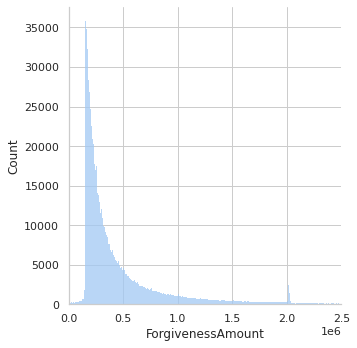

In [ ]:
#distribution of cont. variable

sns.displot(df, x="ForgivenessAmount", kind="hist", color="b")
# change the limits of X-axis
plt.xlim(0,2500000)
plt.show()

We can see that the vast majority of loans were less than 1 million. 
We do see a small spike around the 2 million-dollar mark. That is interesting. 
Lets get more granular around the mode and see what amount was most frequent. 

In [ ]:
print('The most frequent amount issued/forgiven was $', df['ForgivenessAmount'].mode())

The most frequent amount issued/forgiven was $ 0    150830.14
dtype: float64


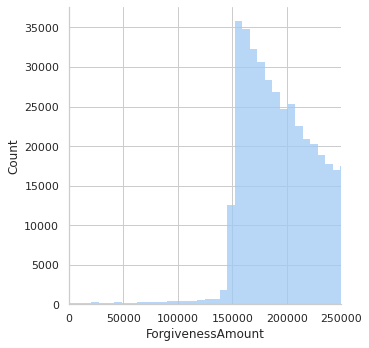

In [ ]:
sns.displot(df, x="ForgivenessAmount", kind="hist", color="b")
# change the limits of X-axis
plt.xlim(0,250000)
plt.show()

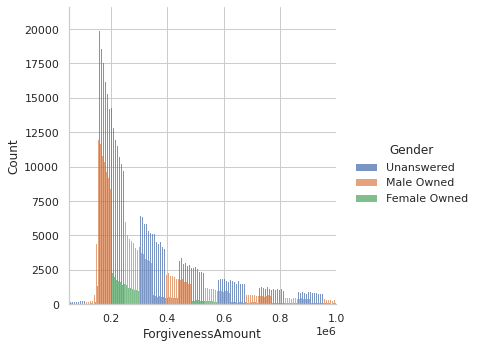

count         968531
unique             3
top       Unanswered
freq          581726
Name: Gender, dtype: object

In [ ]:
#let's look at amount by gender? and maybe veteran status? we'll zero in on the dense area of disribution

sns.displot(df, x="ForgivenessAmount", hue="Gender", multiple="dodge")
plt.xlim(50000, 1000000)
plt.show()
df['Gender'].describe()

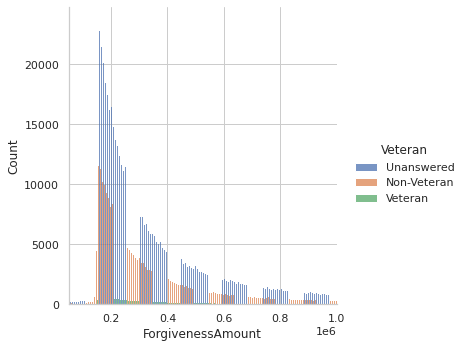

count         968531
unique             3
top       Unanswered
freq          659937
Name: Veteran, dtype: object

In [ ]:
sns.displot(df, x="ForgivenessAmount", hue="Veteran", multiple="dodge")
plt.xlim(50000, 1000000)
plt.show()
df['Veteran'].describe()

###I've realized there isn't a whole lot of useful modeling we can do here...most of the samples don't even include race, ethnicity, etc. 

I guess we could look at state, jobs reported, race, ethnicity, business type, to do some modeling? Most of the rest of the features aren't all that useful to the general public or don't mean anything. 


I think we need some feature engineering here...lots of features and we have no idea if they're important or not. 


In [ ]:
#for one, we need to drop some features that could have thousands of levels...like address, date approved, etc. 
#let's just pick the features we want to include

model_df = df[['BorrowerState', 'JobsReported', 'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran', 'ForgivenessAmount']]


In [ ]:
model_df.head()

,BorrowerState,JobsReported,Race,Ethnicity,BusinessType,Gender,Veteran,ForgivenessAmount
0,NaN,62.0,Unanswered,Unknown/NotStated,Corporation,Unanswered,Unanswered,773553.37
1,NaN,73.0,White,Unknown/NotStated,Sole Proprietorship,Male Owned,Non-Veteran,746336.24
2,NaN,75.0,Unanswered,Unknown/NotStated,Non-Profit Organization,Unanswered,Unanswered,696677.49
3,NaN,21.0,American Indian or Alaska Native,Not Hispanic or Latino,Corporation,Male Owned,Non-Veteran,395264.11
4,NaN,25.0,Unanswered,Unknown/NotStated,NaN,Unanswered,Unanswered,370819.35


In [ ]:
total = model_df.isnull().sum().sort_values(ascending=False)
percent = (model_df.isnull().sum()/model_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
ForgivenessAmount,94,0.020520
BorrowerState,13,0.002838
BusinessType,9,0.001965
JobsReported,1,0.000218
Race,1,0.000218
Ethnicity,1,0.000218
Gender,1,0.000218
Veteran,1,0.000218


In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['ForgivenessAmount'].skew())
print("Kurtosis: %f" % df['ForgivenessAmount'].kurt())

Skewness: 3.863594
Kurtosis: 22.170400


So the target variable is highly kurtotic, as normal is 0.0. 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurtosis.html

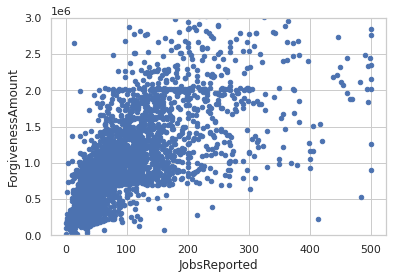

In [ ]:
#look at jobs and target

var = 'JobsReported'
data = pd.concat([model_df['ForgivenessAmount'], model_df[var]], axis=1)
data.plot.scatter(x=var, y='ForgivenessAmount', ylim=(0,3000000));

In [ ]:
#encode categorical variables
catdf = model_df.select_dtypes(include = object)
cat_features = [i for i in catdf.columns]
cat_features

['BorrowerState', 'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran']

In [ ]:
cat_encoded = pd.get_dummies(df[cat_features], drop_first = True)
cat_encoded.head()

,BorrowerState_AL,Race_Asian,Race_Black or African American,Race_Eskimo & Aleut,Race_Native Hawaiian or Other Pacific Islander,Race_Unanswered,Race_White,Ethnicity_Not Hispanic or Latino,Ethnicity_Unknown/NotStated,BusinessType_501(c)6 – Non Profit Membership,...,BusinessType_Professional Association,BusinessType_Self-Employed Individuals,BusinessType_Single Member LLC,BusinessType_Sole Proprietorship,BusinessType_Subchapter S Corporation,BusinessType_Trust,Gender_Male Owned,Gender_Unanswered,Veteran_Unanswered,Veteran_Veteran
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
model_df[cat_encoded.columns] = cat_encoded
model_df.head()

,BorrowerState,JobsReported,Race,Ethnicity,BusinessType,Gender,Veteran,ForgivenessAmount,BorrowerState_AL,Race_Asian,...,BusinessType_Professional Association,BusinessType_Self-Employed Individuals,BusinessType_Single Member LLC,BusinessType_Sole Proprietorship,BusinessType_Subchapter S Corporation,BusinessType_Trust,Gender_Male Owned,Gender_Unanswered,Veteran_Unanswered,Veteran_Veteran
0,NaN,62.0,Unanswered,Unknown/NotStated,Corporation,Unanswered,Unanswered,773553.37,0,0,...,0,0,0,0,0,0,0,1,1,0
1,NaN,73.0,White,Unknown/NotStated,Sole Proprietorship,Male Owned,Non-Veteran,746336.24,0,0,...,0,0,0,1,0,0,1,0,0,0
2,NaN,75.0,Unanswered,Unknown/NotStated,Non-Profit Organization,Unanswered,Unanswered,696677.49,0,0,...,0,0,0,0,0,0,0,1,1,0
3,NaN,21.0,American Indian or Alaska Native,Not Hispanic or Latino,Corporation,Male Owned,Non-Veteran,395264.11,0,0,...,0,0,0,0,0,0,1,0,0,0
4,NaN,25.0,Unanswered,Unknown/NotStated,NaN,Unanswered,Unanswered,370819.35,0,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
X = [i for i in model_df.columns if i != 'ForgivenessAmount']
X = df[X]

y = df['ForgivenessAmount']

In [ ]:
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
sel = VarianceThreshold(threshold=0)
sel.fit(X_train)

VarianceThreshold(threshold=0)

In [ ]:
sum(sel.get_support())

93

In [ ]:
# print the constant features
print(
    len([
        x for x in X_train.columns
        if x not in X_train.columns[sel.get_support()]
    ]))

[x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

1


['BusinessType_501(c)19 – Non Profit Veterans']

In [ ]:
#get rid of this feature

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [ ]:
# check the shape of training and test set

X_train.shape, X_test.shape

((677971, 93), (290560, 93))